In [32]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [34]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [35]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [36]:
tf.keras.backend.clear_session()

In [37]:
subject = 'Goiás - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [38]:
data = pd.read_csv('2003_mo_model_input_GO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - Consumo de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,56.459960,97.447,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,56.789152,97.256,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,57.140263,101.442,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,57.649192,98.217,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,58.213295,112.540,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


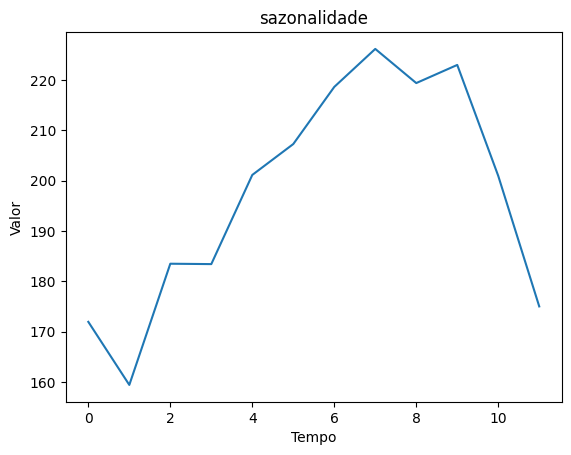

,sazonalidade
sazonalidade,
0,171.935211
1,159.402557
2,183.484095
3,183.408045
4,201.125939
5,207.265015
6,218.615640
7,226.163682
8,219.379185


In [39]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [40]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Goiás - Consumo de Cimento (t)
0,2003-1,56.459960,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,171.935211,97.447
1,2003-2,56.789152,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,159.402557,97.256
2,2003-3,57.140263,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,183.484095,101.442
3,2003-4,57.649192,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,183.408045,98.217
4,2003-5,58.213295,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,201.125939,112.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.125939,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.265015,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218.615640,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.163682,NaN


In [41]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
256        NaN
257        NaN
258        NaN
259        NaN
260        NaN
Name: Goiás - Consumo de Cimento (t), Length: 261, dtype: float64

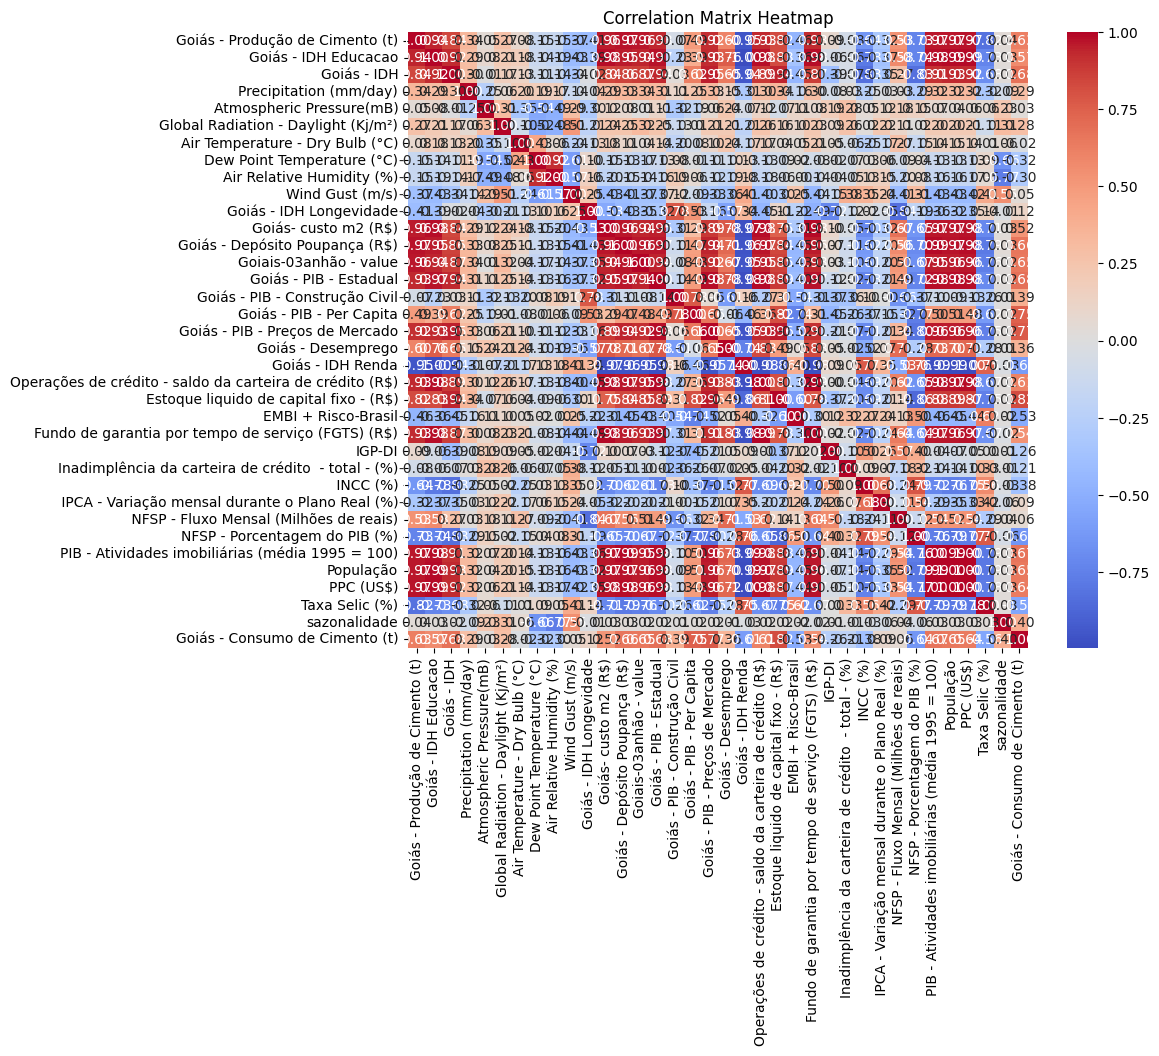

In [42]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [44]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Goiás - Produção de Cimento (t),5.529583e+03
1,Goiás - IDH Educacao,2.005330e+05
2,Goiás - IDH,3.844528e+08
3,Precipitation (mm/day),2.491568e+00
4,Atmospheric Pressure(mB),8.202494e+00
5,Global Radiation - Daylight (Kj/m²),7.322816e+00
6,Air Temperature - Dry Bulb (°C),5.937975e+01
7,Dew Point Temperature (°C),5.282563e+02
8,Air Relative Humidity (%),4.848121e+02
9,Wind Gust (m/s),2.789956e+01


In [45]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 6


,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,56.459960,0.706514,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,8.179785,0.767692,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,171.935211
1,56.789152,0.706866,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,8.174086,0.767405,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,159.402557
2,57.140263,0.707217,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,8.168386,0.767117,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,183.484095
3,57.649192,0.707569,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,8.162687,0.766830,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,183.408045
4,58.213295,0.707920,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,8.156988,0.766543,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,201.125939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,160.256496,0.760395,2.068634,932.907447,1467.507774,24.840849,12.739925,52.870570,1.174364,27869.657951,1.332859e+07,0.399245,1.108160e+08,5.579131e+06,8.829475,0.727877,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,226.163682
200,161.174402,0.760326,2.409023,932.020800,1472.783618,25.241686,13.895494,55.516371,1.132926,28082.722145,1.353202e+07,0.401743,1.107145e+08,5.579717e+06,8.812662,0.727826,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,219.379185
201,162.373078,0.760257,2.429872,931.445160,1442.570976,25.124075,15.621861,60.963541,1.095558,28305.060701,1.373545e+07,0.404621,1.106131e+08,5.580303e+06,8.795849,0.727775,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,222.982664
202,162.835725,0.760187,2.727672,931.245593,1407.215061,24.907234,16.865166,65.769274,1.032548,28536.873955,1.393888e+07,0.407586,1.105116e+08,5.580888e+06,8.779036,0.727723,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,200.940214


In [46]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.831801,0.244512,-0.182881,0.968981,0.323023,1.195926,1.290196,-0.399657,-1.472322,-1.556368,-1.004880,-1.780763,-1.659856,-0.454936,1.925702,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.811076,-0.130437,0.137566,0.939260,-0.223586,0.929429,1.188173,-0.208253,-1.455575,-1.546893,-1.024709,-1.762213,-1.604545,-0.465590,1.902553,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.790351,-0.516839,0.483081,0.536329,-0.974081,0.441553,0.929660,-0.092510,-1.439922,-1.537417,-1.052883,-1.743664,-1.549235,-0.476244,1.879404,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.769626,-0.647731,1.065853,0.630470,-1.708158,-0.321827,0.334645,0.489565,-1.425079,-1.527942,-1.077772,-1.725115,-1.493925,-0.486897,1.856255,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.748900,-1.476828,1.451888,0.729012,-2.157729,-1.071096,-0.366735,0.985079,-1.409147,-1.518466,-1.109596,-1.706565,-1.438614,-0.497551,1.833106,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.344021,-0.037475,0.569817,0.741500,1.409700,-1.407314,-2.009751,-0.641021,1.838547,1.731590,1.428255,0.914317,-0.982430,0.759542,-1.283131,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.339948,0.627207,-0.134241,0.804874,1.910810,-0.863362,-1.589556,-0.899769,1.879397,1.802797,1.471925,0.898324,-0.975904,0.728113,-1.287261,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.335875,0.667921,-0.591338,0.441957,1.763777,-0.050723,-0.724461,-1.133104,1.922027,1.874004,1.522255,0.882331,-0.969378,0.696684,-1.291391,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,1.331802,1.249438,-0.749807,0.017258,1.492692,0.534528,0.038765,-1.526558,1.966472,1.945210,1.574096,0.866337,-0.962852,0.665255,-1.295521,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [47]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.831801,0.244512,-0.182881,0.968981,0.323023,1.195926,1.290196,-0.399657,-1.472322,-1.556368,-1.004880,-1.780763,-1.659856,-0.454936,1.925702,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.811076,-0.130437,0.137566,0.939260,-0.223586,0.929429,1.188173,-0.208253,-1.455575,-1.546893,-1.024709,-1.762213,-1.604545,-0.465590,1.902553,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.790351,-0.516839,0.483081,0.536329,-0.974081,0.441553,0.929660,-0.092510,-1.439922,-1.537417,-1.052883,-1.743664,-1.549235,-0.476244,1.879404,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.769626,-0.647731,1.065853,0.630470,-1.708158,-0.321827,0.334645,0.489565,-1.425079,-1.527942,-1.077772,-1.725115,-1.493925,-0.486897,1.856255,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.748900,-1.476828,1.451888,0.729012,-2.157729,-1.071096,-0.366735,0.985079,-1.409147,-1.518466,-1.109596,-1.706565,-1.438614,-0.497551,1.833106,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.364595,-0.258101,0.305272,-0.107788,0.233973,-0.815017,-0.991155,-0.799181,1.485448,1.161147,1.094687,1.062326,-1.109464,0.958314,-1.235291,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,1.366182,-0.171272,-0.184985,-0.049574,0.610763,-0.305372,-0.570325,-0.969386,1.504142,1.175546,1.109879,1.055115,-1.093193,0.962560,-1.239077,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.367770,-0.208880,-0.251755,-0.073963,0.809897,0.284997,-0.041262,-1.048311,1.524211,1.189946,1.125215,1.047903,-1.076922,0.966806,-1.242863,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,1.369357,-0.191102,-0.348735,0.011434,0.831702,0.559706,0.278344,-1.186939,1.547865,1.204345,1.147835,1.040692,-1.060651,0.971053,-1.246649,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [48]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
187    237.382
188    240.479
189    237.489
190    226.373
191    191.241
Name: Goiás - Consumo de Cimento (t), Length: 192, dtype: float64

In [49]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [50]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 27)

In [51]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,1.242242,-0.850293,-0.371797,0.115039,1.500298,0.991543,0.545789,-0.713198,0.924810,0.576885,0.819009,1.116355,-1.040701,1.785750,-1.223559,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,1.244326,-0.280666,0.113862,0.564000,1.324191,0.763560,0.299200,-0.801378,0.945054,0.595828,0.826922,1.119312,-1.057440,1.723803,-1.225014,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,1.246410,-0.409021,0.631579,0.280074,0.604217,0.301169,0.035587,-0.615801,0.964830,0.614772,0.834918,1.122269,-1.074178,1.661857,-1.226470,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,1.248495,-0.124244,1.050489,0.339357,-0.033172,-0.441144,-0.567441,-0.395181,0.984987,0.633716,0.843002,1.125225,-1.090917,1.599910,-1.227925,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,1.250579,0.138128,1.436596,0.042606,-0.489320,-0.974209,-0.962724,-0.300568,1.004372,0.652659,0.851106,1.128182,-1.107655,1.537963,-1.229381,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,1.252663,-0.529764,1.444770,0.486437,-0.233588,-1.472210,-1.591853,0.145376,1.023595,0.671603,0.859231,1.131139,-1.124394,1.476017,-1.230836,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,1.254748,-0.805478,1.000515,0.909119,0.376841,-1.452727,-1.799507,0.252952,1.042990,0.690547,0.866649,1.134096,-1.141132,1.414070,-1.232292,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,1.256832,-1.430669,0.446817,0.669277,0.804230,-0.980391,-1.439620,0.234790,1.062763,0.709490,0.874859,1.137053,-1.157871,1.352124,-1.233747,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,1.258917,-0.943815,-0.051513,0.722510,1.110846,-0.465839,-0.997086,0.308512,1.079954,0.728434,0.883020,1.140010,-1.174609,1.290177,-1.235203,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,1.261001,-0.314233,-0.427280,0.421427,0.987989,0.150113,-0.281883,0.023121,1.097502,0.747378,0.891133,1.142967,-1.191348,1.228230,-1.236658,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [52]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 27)

In [53]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [54]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(108, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [55]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [56]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2561305211, 3675259964, 2451106997, 3377606479, 4240370002, 1828947788, 886888036, 794863924, 2849801559, 2311894460]


Step: 0 ___________________________________________
val_loss: 541.768310546875
winner_seed: 2561305211


Step: 1 ___________________________________________
val_loss: 593.594482421875


Step: 2 ___________________________________________
val_loss: 477.51141357421875
winner_seed: 2451106997


Step: 3 ___________________________________________
val_loss: 475.0384826660156
winner_seed: 3377606479


Step: 4 ___________________________________________
val_loss: 721.5775146484375


Step: 5 ___________________________________________
val_loss: 409.34503173828125
winner_seed: 1828947788


Step: 6 ___________________________________________
val_loss: 530.5672607421875


Step: 7 ___________________________________________
val_loss: 438.6543884277344


Step: 8 ___________________________________________
val_loss: 407.75927734375
winner_seed: 2849801559


Step: 9 _______________

In [57]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 86ms/step - loss: 30032.6641 - val_loss: 1888.6079
Epoch 2/10000
5/5 [==============================] - 0s 6ms/step - loss: 1746.5951 - val_loss: 2731.8054
Epoch 3/10000
5/5 [==============================] - 0s 6ms/step - loss: 1928.9102 - val_loss: 3153.1516
Epoch 4/10000
5/5 [==============================] - 0s 6ms/step - loss: 1918.2079 - val_loss: 1204.7030
Epoch 5/10000
5/5 [==============================] - 0s 6ms/step - loss: 1698.4797 - val_loss: 2471.8347
Epoch 6/10000
5/5 [==============================] - 0s 7ms/step - loss: 1975.2633 - val_loss: 3057.2771
Epoch 7/10000
5/5 [==============================] - 0s 6ms/step - loss: 1917.0184 - val_loss: 1166.7867
Epoch 8/10000
5/5 [==============================] - 0s 6ms/step - loss: 1477.4991 - val_loss: 974.2869
Epoch 9/10000
5/5 [==============================] - 0s 6ms/step - loss: 1405.1105 - val_loss: 1980.2081
Epoch 10/10000
5/5 [==============================] - 

5/5 [==============================] - 0s 6ms/step - loss: 205.2437 - val_loss: 540.4500
Epoch 80/10000
5/5 [==============================] - 0s 6ms/step - loss: 180.2075 - val_loss: 628.6057
Epoch 81/10000
5/5 [==============================] - 0s 7ms/step - loss: 213.5896 - val_loss: 1084.3171
Epoch 82/10000
5/5 [==============================] - 0s 6ms/step - loss: 432.7978 - val_loss: 918.0054
Epoch 83/10000
5/5 [==============================] - 0s 6ms/step - loss: 236.0712 - val_loss: 900.7916
Epoch 84/10000
5/5 [==============================] - 0s 6ms/step - loss: 180.8514 - val_loss: 491.6854
Epoch 85/10000
5/5 [==============================] - 0s 6ms/step - loss: 244.4218 - val_loss: 488.1227
Epoch 86/10000
5/5 [==============================] - 0s 6ms/step - loss: 211.8963 - val_loss: 597.4984
Epoch 87/10000
5/5 [==============================] - 0s 6ms/step - loss: 185.2147 - val_loss: 444.7346
Epoch 88/10000
5/5 [==============================] - 0s 6ms/step - loss: 248.

5/5 [==============================] - 0s 7ms/step - loss: 133.4638 - val_loss: 490.3560
Epoch 158/10000
5/5 [==============================] - 0s 7ms/step - loss: 184.3475 - val_loss: 645.1525
Epoch 159/10000
5/5 [==============================] - 0s 6ms/step - loss: 163.0539 - val_loss: 547.4651
Epoch 160/10000
5/5 [==============================] - 0s 7ms/step - loss: 112.3735 - val_loss: 490.0316
Epoch 161/10000
5/5 [==============================] - 0s 6ms/step - loss: 121.5920 - val_loss: 893.2128
Epoch 162/10000
5/5 [==============================] - 0s 7ms/step - loss: 140.0769 - val_loss: 577.5971
Epoch 163/10000
5/5 [==============================] - 0s 7ms/step - loss: 160.8336 - val_loss: 466.1317
Epoch 164/10000
5/5 [==============================] - 0s 7ms/step - loss: 153.8227 - val_loss: 568.6101
Epoch 165/10000
5/5 [==============================] - 0s 7ms/step - loss: 118.9927 - val_loss: 680.5593
Epoch 166/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 8ms/step - loss: 92.0299 - val_loss: 554.7809
Epoch 236/10000
5/5 [==============================] - 0s 7ms/step - loss: 112.7854 - val_loss: 535.3912
Epoch 237/10000
5/5 [==============================] - 0s 7ms/step - loss: 107.3535 - val_loss: 569.7122
Epoch 238/10000
5/5 [==============================] - 0s 7ms/step - loss: 89.0970 - val_loss: 697.4308
Epoch 239/10000
5/5 [==============================] - 0s 7ms/step - loss: 102.6712 - val_loss: 481.0594
Epoch 240/10000
5/5 [==============================] - 0s 7ms/step - loss: 117.3003 - val_loss: 590.0793
Epoch 241/10000
5/5 [==============================] - 0s 7ms/step - loss: 87.5866 - val_loss: 825.0595
Epoch 242/10000
5/5 [==============================] - 0s 7ms/step - loss: 108.8817 - val_loss: 583.4731
Epoch 243/10000
5/5 [==============================] - 0s 8ms/step - loss: 86.0807 - val_loss: 673.0160
Epoch 244/10000
5/5 [==============================] - 0s 7ms/step - loss: 

5/5 [==============================] - 0s 8ms/step - loss: 75.8634 - val_loss: 553.5632
Epoch 314/10000
5/5 [==============================] - 0s 7ms/step - loss: 70.2345 - val_loss: 566.7966
Epoch 315/10000
5/5 [==============================] - 0s 7ms/step - loss: 75.9056 - val_loss: 515.6092
Epoch 316/10000
5/5 [==============================] - 0s 7ms/step - loss: 86.6659 - val_loss: 527.4404
Epoch 317/10000
5/5 [==============================] - 0s 7ms/step - loss: 88.4242 - val_loss: 544.0179
Epoch 318/10000
5/5 [==============================] - 0s 7ms/step - loss: 69.5491 - val_loss: 568.7815
Epoch 319/10000
5/5 [==============================] - 0s 7ms/step - loss: 76.5801 - val_loss: 749.5283
Epoch 320/10000
5/5 [==============================] - 0s 7ms/step - loss: 126.8699 - val_loss: 533.3879
Epoch 321/10000
5/5 [==============================] - 0s 7ms/step - loss: 75.6852 - val_loss: 512.1559
Epoch 322/10000
5/5 [==============================] - 0s 7ms/step - loss: 79.9

Epoch 392/10000
5/5 [==============================] - 0s 7ms/step - loss: 60.8381 - val_loss: 558.7690
Epoch 393/10000
5/5 [==============================] - 0s 8ms/step - loss: 74.2510 - val_loss: 564.5888
Epoch 394/10000
5/5 [==============================] - 0s 7ms/step - loss: 79.0045 - val_loss: 562.3759
Epoch 395/10000
5/5 [==============================] - 0s 8ms/step - loss: 64.3419 - val_loss: 598.9292
Epoch 396/10000
5/5 [==============================] - 0s 8ms/step - loss: 69.5728 - val_loss: 618.0217
Epoch 397/10000
5/5 [==============================] - 0s 8ms/step - loss: 70.0185 - val_loss: 597.0045
Epoch 398/10000
5/5 [==============================] - 0s 8ms/step - loss: 69.4825 - val_loss: 538.9879
Epoch 399/10000
5/5 [==============================] - 0s 7ms/step - loss: 81.9326 - val_loss: 555.4719
Epoch 400/10000
5/5 [==============================] - 0s 7ms/step - loss: 80.3863 - val_loss: 542.5210
Epoch 401/10000
5/5 [==============================] - 0s 7ms/st

Epoch 471/10000
5/5 [==============================] - 0s 7ms/step - loss: 48.8394 - val_loss: 505.9453
Epoch 472/10000
5/5 [==============================] - 0s 7ms/step - loss: 69.0865 - val_loss: 612.0708
Epoch 473/10000
5/5 [==============================] - 0s 7ms/step - loss: 52.0652 - val_loss: 590.9364
Epoch 474/10000
5/5 [==============================] - 0s 7ms/step - loss: 57.1595 - val_loss: 509.4095
Epoch 475/10000
5/5 [==============================] - 0s 7ms/step - loss: 48.0629 - val_loss: 548.1478
Epoch 476/10000
5/5 [==============================] - 0s 7ms/step - loss: 60.1945 - val_loss: 641.0187
Epoch 477/10000
5/5 [==============================] - 0s 6ms/step - loss: 66.8327 - val_loss: 518.7047
Epoch 478/10000
5/5 [==============================] - 0s 7ms/step - loss: 81.6199 - val_loss: 505.4477
Epoch 479/10000
5/5 [==============================] - 0s 7ms/step - loss: 64.6522 - val_loss: 571.7075
Epoch 480/10000
5/5 [==============================] - 0s 7ms/st

Epoch 550/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.6639 - val_loss: 567.5611
Epoch 551/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.2035 - val_loss: 591.1717
Epoch 552/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.7914 - val_loss: 586.1400
Epoch 553/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.6343 - val_loss: 598.1852
Epoch 554/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.6296 - val_loss: 583.7578
Epoch 555/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.0830 - val_loss: 557.7852
Epoch 556/10000
5/5 [==============================] - 0s 7ms/step - loss: 66.7592 - val_loss: 552.5201
Epoch 557/10000
5/5 [==============================] - 0s 6ms/step - loss: 51.6514 - val_loss: 554.4282
Epoch 558/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.9336 - val_loss: 633.6648
Epoch 559/10000
5/5 [==============================] - 0s 7ms/st

Epoch 629/10000
5/5 [==============================] - 0s 7ms/step - loss: 71.9043 - val_loss: 547.8948
Epoch 630/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.2486 - val_loss: 523.8497
Epoch 631/10000
5/5 [==============================] - 0s 7ms/step - loss: 35.6926 - val_loss: 510.2295
Epoch 632/10000
5/5 [==============================] - 0s 7ms/step - loss: 33.7683 - val_loss: 504.2164
Epoch 633/10000
5/5 [==============================] - 0s 7ms/step - loss: 33.6562 - val_loss: 498.9042
Epoch 634/10000
5/5 [==============================] - 0s 6ms/step - loss: 44.4947 - val_loss: 497.9057
Epoch 635/10000
5/5 [==============================] - 0s 7ms/step - loss: 36.2647 - val_loss: 519.5540
Epoch 636/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.1546 - val_loss: 493.1361
Epoch 637/10000
5/5 [==============================] - 0s 8ms/step - loss: 37.4574 - val_loss: 523.2662
Epoch 638/10000
5/5 [==============================] - 0s 7ms/st

Epoch 708/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.2316 - val_loss: 675.9496
Epoch 709/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.8120 - val_loss: 543.0790
Epoch 710/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.5632 - val_loss: 547.8937
Epoch 711/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.7854 - val_loss: 524.6884
Epoch 712/10000
5/5 [==============================] - 0s 7ms/step - loss: 37.8413 - val_loss: 554.2547
Epoch 713/10000
5/5 [==============================] - 0s 7ms/step - loss: 41.4050 - val_loss: 588.1723
Epoch 714/10000
5/5 [==============================] - 0s 7ms/step - loss: 41.4222 - val_loss: 520.1538
Epoch 715/10000
5/5 [==============================] - 0s 7ms/step - loss: 31.9842 - val_loss: 506.0874
Epoch 716/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.3641 - val_loss: 597.6259
Epoch 717/10000
5/5 [==============================] - 0s 6ms/st

Epoch 787/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.0828 - val_loss: 492.4091
Epoch 788/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.2037 - val_loss: 577.6334
Epoch 789/10000
5/5 [==============================] - 0s 7ms/step - loss: 41.2045 - val_loss: 520.2560
Epoch 790/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.1925 - val_loss: 493.2156
Epoch 791/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.1684 - val_loss: 538.4588
Epoch 792/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.9899 - val_loss: 512.8550
Epoch 793/10000
5/5 [==============================] - 0s 7ms/step - loss: 32.3504 - val_loss: 512.3314
Epoch 794/10000
5/5 [==============================] - 0s 6ms/step - loss: 42.4927 - val_loss: 591.7166
Epoch 795/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.5967 - val_loss: 544.7408
Epoch 796/10000
5/5 [==============================] - 0s 7ms/st

Epoch 866/10000
5/5 [==============================] - 0s 7ms/step - loss: 32.3263 - val_loss: 489.5437
Epoch 867/10000
5/5 [==============================] - 0s 7ms/step - loss: 41.6265 - val_loss: 736.1133
Epoch 868/10000
5/5 [==============================] - 0s 7ms/step - loss: 52.8530 - val_loss: 499.2604
Epoch 869/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.6985 - val_loss: 508.6433
Epoch 870/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.8780 - val_loss: 504.6442
Epoch 871/10000
5/5 [==============================] - 0s 7ms/step - loss: 35.2361 - val_loss: 482.1898
Epoch 872/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.4714 - val_loss: 482.5221
Epoch 873/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.1275 - val_loss: 548.9835
Epoch 874/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.7099 - val_loss: 493.4117
Epoch 875/10000
5/5 [==============================] - 0s 7ms/st

Epoch 945/10000
5/5 [==============================] - 0s 7ms/step - loss: 36.0491 - val_loss: 489.4661
Epoch 946/10000
5/5 [==============================] - 0s 7ms/step - loss: 32.3846 - val_loss: 518.3873
Epoch 947/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.5357 - val_loss: 507.2704
Epoch 948/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.6722 - val_loss: 492.9379
Epoch 949/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.8902 - val_loss: 532.7147
Epoch 950/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.2568 - val_loss: 491.6205
Epoch 951/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.7016 - val_loss: 518.9338
Epoch 952/10000
5/5 [==============================] - 0s 7ms/step - loss: 31.7379 - val_loss: 500.0445
Epoch 953/10000
5/5 [==============================] - 0s 6ms/step - loss: 28.8818 - val_loss: 546.7614
Epoch 954/10000
5/5 [==============================] - 0s 7ms/st

5/5 [==============================] - 0s 7ms/step - loss: 26.7883 - val_loss: 460.7211
Epoch 1024/10000
5/5 [==============================] - 0s 7ms/step - loss: 31.3382 - val_loss: 487.0213
Epoch 1025/10000
5/5 [==============================] - 0s 8ms/step - loss: 25.6192 - val_loss: 502.5192
Epoch 1026/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.2568 - val_loss: 459.3342
Epoch 1027/10000
5/5 [==============================] - 0s 7ms/step - loss: 32.6339 - val_loss: 595.6076
Epoch 1028/10000
5/5 [==============================] - 0s 7ms/step - loss: 42.0902 - val_loss: 456.4441
Epoch 1029/10000
5/5 [==============================] - 0s 7ms/step - loss: 27.4163 - val_loss: 483.9565
Epoch 1030/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.5381 - val_loss: 527.2886
Epoch 1031/10000
5/5 [==============================] - 0s 7ms/step - loss: 33.2850 - val_loss: 563.5391
Epoch 1032/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 39.6325 - val_loss: 534.0378
Epoch 1102/10000
5/5 [==============================] - 0s 7ms/step - loss: 27.0346 - val_loss: 515.8195
Epoch 1103/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.1234 - val_loss: 482.3737
Epoch 1104/10000
5/5 [==============================] - 0s 7ms/step - loss: 31.5020 - val_loss: 532.3107
Epoch 1105/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.8233 - val_loss: 527.2853
Epoch 1106/10000
5/5 [==============================] - 0s 7ms/step - loss: 35.2445 - val_loss: 560.9528
Epoch 1107/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.4032 - val_loss: 570.3882
Epoch 1108/10000
5/5 [==============================] - 0s 7ms/step - loss: 27.6696 - val_loss: 485.7357
Epoch 1109/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.6205 - val_loss: 572.4501
Epoch 1110/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 27.3611 - val_loss: 542.5007
Epoch 1180/10000
5/5 [==============================] - 0s 7ms/step - loss: 27.6162 - val_loss: 541.2732
Epoch 1181/10000
5/5 [==============================] - 0s 6ms/step - loss: 27.4274 - val_loss: 533.6420
Epoch 1182/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.5132 - val_loss: 539.2856
Epoch 1183/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.6085 - val_loss: 553.1273
Epoch 1184/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.7359 - val_loss: 535.4962
Epoch 1185/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.6240 - val_loss: 545.7143
Epoch 1186/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.5260 - val_loss: 550.4822
Epoch 1187/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.1056 - val_loss: 540.4351
Epoch 1188/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 23.8338 - val_loss: 532.8290
Epoch 1258/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.5994 - val_loss: 545.1310
Epoch 1259/10000
5/5 [==============================] - 0s 6ms/step - loss: 25.2013 - val_loss: 474.2709
Epoch 1260/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.9700 - val_loss: 514.9641
Epoch 1261/10000
5/5 [==============================] - 0s 8ms/step - loss: 27.1531 - val_loss: 525.2789
Epoch 1262/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.4708 - val_loss: 557.4804
Epoch 1263/10000
5/5 [==============================] - 0s 8ms/step - loss: 23.2428 - val_loss: 522.8325
Epoch 1264/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.6953 - val_loss: 541.4277
Epoch 1265/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.1155 - val_loss: 518.1962
Epoch 1266/10000
5/5 [==============================] - 0s 8ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 41.8701 - val_loss: 536.0793
Epoch 1336/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.9602 - val_loss: 522.4710
Epoch 1337/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.1218 - val_loss: 506.8833
Epoch 1338/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.4296 - val_loss: 665.6570
Epoch 1339/10000
5/5 [==============================] - 0s 7ms/step - loss: 33.6023 - val_loss: 550.3093
Epoch 1340/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.9744 - val_loss: 536.1591
Epoch 1341/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.7863 - val_loss: 565.3784
Epoch 1342/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.9903 - val_loss: 609.6463
Epoch 1343/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.1241 - val_loss: 624.7390
Epoch 1344/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 24.7680 - val_loss: 588.7338
Epoch 1414/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.0268 - val_loss: 554.0829
Epoch 1415/10000
5/5 [==============================] - 0s 7ms/step - loss: 31.6802 - val_loss: 556.8752
Epoch 1416/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.6384 - val_loss: 585.8433
Epoch 1417/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.7723 - val_loss: 624.5192
Epoch 1418/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.3693 - val_loss: 576.6450
Epoch 1419/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.2253 - val_loss: 561.8785
Epoch 1420/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.5355 - val_loss: 561.9746
Epoch 1421/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.4791 - val_loss: 555.4820
Epoch 1422/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 22.6320 - val_loss: 561.2333
Epoch 1492/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.6264 - val_loss: 756.0957
Epoch 1493/10000
5/5 [==============================] - 0s 7ms/step - loss: 63.9813 - val_loss: 543.4056
Epoch 1494/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.1905 - val_loss: 667.9918
Epoch 1495/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.7366 - val_loss: 606.6245
Epoch 1496/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.0455 - val_loss: 564.3249
Epoch 1497/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.9635 - val_loss: 602.7891
Epoch 1498/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.8309 - val_loss: 599.7816
Epoch 1499/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.1724 - val_loss: 645.1554
Epoch 1500/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 21.2405 - val_loss: 535.8428
Epoch 1570/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.7482 - val_loss: 537.6146
Epoch 1571/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.7040 - val_loss: 552.7065
Epoch 1572/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.3958 - val_loss: 595.0576
Epoch 1573/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.5853 - val_loss: 584.5181
Epoch 1574/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.6619 - val_loss: 602.3234
Epoch 1575/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.0638 - val_loss: 577.5384
Epoch 1576/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.9074 - val_loss: 601.6878
Epoch 1577/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.8898 - val_loss: 568.1704
Epoch 1578/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 20.1505 - val_loss: 513.9131
Epoch 1648/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.2520 - val_loss: 492.4762
Epoch 1649/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.0031 - val_loss: 472.9605
Epoch 1650/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.4388 - val_loss: 520.0192
Epoch 1651/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.6360 - val_loss: 494.1937
Epoch 1652/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.0620 - val_loss: 535.5233
Epoch 1653/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.7435 - val_loss: 527.9653
Epoch 1654/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.9132 - val_loss: 519.8855
Epoch 1655/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.1978 - val_loss: 533.6423
Epoch 1656/10000
5/5 [==============================] - 0s 7ms/step - lo

In [58]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [59]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,177.155869,153.879852,185.81665,157.28772,217.125381,210.449402,231.223999,229.497345,228.307953,220.780975,188.962646,159.083359
Target,206.9,197.392,203.171,226.45,260.121,242.536,265.352,269.361,259.469,237.556,214.586,199.241
Error,29.744125,43.512146,17.354355,69.162277,42.995621,32.086594,34.127991,39.863647,31.161041,16.775024,25.623352,40.157639


In [60]:
display(mae)
display(mape)

35.21365

0.1534083

In [61]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [62]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined